# Variational Autoencoders (Fashion MNIST)
Skeleton code from https://github.com/tudor-berariu/ann2018

## 1. Miscellaneous

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
from torch import Tensor

assert torch.cuda.is_available()

print('sys version: ', sys.version)
print('torch version: ', torch.version.__version__)

sys version:  3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 19:16:44) 
[GCC 7.3.0]
torch version:  0.4.1


In [2]:
device = torch.device('cuda')
torch.backends.cudnn.deterministic = True
torch.manual_seed(67)
np.random.seed(67)

In [3]:
def grid_vis(X, rows=5, cols=15, pad=1, norm_img=False, plt_title='', figsize=None):
    X = X[:rows*cols].cpu().numpy()
    
    if norm_img:
        X_min = X.min(axis=1, keepdims=True)
        X_max = X.max(axis=1, keepdims=True)
        X = (X - X_min) / (X_max - X_min)
        
    if figsize is None:
        figsize=(16, 5)
    
    X_reshaped = X.reshape(-1, 28, 28)
    
    g_d1 = rows
    g_d2 = 28 + 2 * pad
    g_d3 = g_d2 * cols
    grid_rows = np.zeros((g_d1, g_d2, g_d3))
    
    for i in range(rows):
        start_idx = i * cols
        end_idx = (i + 1) * cols
        X_pad = np.pad(X_reshaped[start_idx:end_idx], 
                       [(0,), (pad,), (pad,)], 
                       'constant', constant_values=1)
        grid_rows[i] = np.concatenate(X_pad, axis=1)
    
    grid_imgs = np.concatenate(grid_rows, axis=0)
    plt.figure(figsize=figsize)
    plt.title(plt_title)
    plt.imshow(grid_imgs, cmap='gray')
    plt.axis('off')
    plt.show()

## 2. Fashion MNIST dataset

torch.Size([60000, 1, 28, 28])
cuda:0
torch.Size([10000, 1, 28, 28])
cuda:0


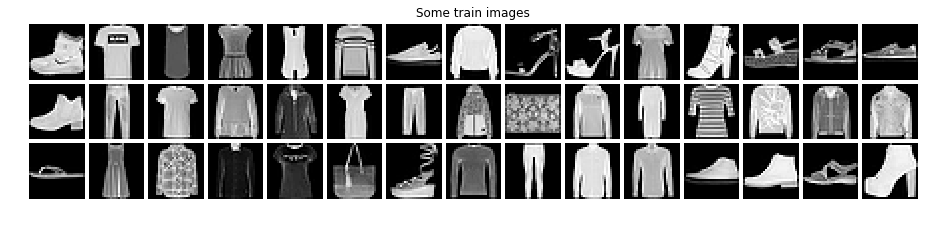

In [4]:
import torchvision
root = './datasets/fashion_mnist/'

fashion_mnist_train = torchvision.datasets.FashionMNIST(root, train=True, download=True)
fashion_mnist_test = torchvision.datasets.FashionMNIST(root, train=False, download=True)

X_train_np = np.array(fashion_mnist_train.train_data, dtype=np.float)
y_train_np = np.array(fashion_mnist_train.train_labels, dtype=np.int)
X_test_np = np.array(fashion_mnist_test.test_data, dtype=np.float)
y_test_np = np.array(fashion_mnist_test.test_labels, dtype=np.int)

X_train = torch.Tensor(X_train_np[:, None, :, :] / 255.).to(device)
y_train = torch.Tensor(y_train_np).to(device, torch.long)
X_test = torch.Tensor(X_test_np[:, None, :, :] / 255.).to(device)
y_test = torch.Tensor(y_test_np).to(device, torch.long)

print(X_train.shape)
print(X_train.device)

print(X_test.shape)
print(X_test.device)

class_desc = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

grid_vis(X_train, rows=3, plt_title='Some train images')

## 3. The Variational Auto-encoder


The encoder computes $q_{\phi}\left(z \mid x\right)$ predicting:

 - $\mu_{\phi}\left(x\right)$ and
 - $\log \sigma_{\phi}^2\left(x\right)$.
 
 
 The decoder computes $p_{\theta}\left(x \mid z\right)$.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, nz: int = 1) -> None:
        super(VAE, self).__init__()
        self.nz = nz  # The number of dimensions in the latent space
        self.encoder = nn.Sequential(nn.Linear(784, 64), nn.ReLU())
        self.mean = nn.Linear(64, nz)  # predicts the mean of p(z|x)
        self.log_var = nn.Linear(64, nz)  # predicts the log-variance of p(z|x)
        self.decoder = nn.Sequential(nn.Linear(nz, 64), nn.ReLU(),
                                     nn.Linear(64, 784))
    
    def forward(self, x):
        x = x.view(-1, 784) # Drop this if you use convolutional encoders

        # Encoding x into mu, and log-var of p(z|x)
        x = self.encoder(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
    
        # ----------------------------------------------------------------
        # TODO 1: compute z = (eps * std) + mean (reparametrization trick)
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        noise = eps * std + mean
        # ----------------------------------------------------------------

        # Decoding z into p(x|z)
        x = self.decoder(noise)
        x = torch.sigmoid(x)

        return x.view(-1, 1, 28, 28), mean, log_var
  
    def generate(self, nsamples: int = None, noise: Tensor = None) -> Tensor:
        # Generate some data
        with torch.no_grad():
            if noise is None:
                noise = torch.randn(nsamples, self.nz).to(device)
            x = self.decoder(noise)
            x = torch.sigmoid(x)
            return x.view(-1, 1, 28, 28)
        
    def get_z(self, x):
        _, mean, log_var = self.forward(x)
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        z = eps * std + mean
        return z

## 4. Training the model

The optimization criterion has two components.

 - the KL divergence between $q_{\phi}\left(z \mid x\right)$ and $p\left(z\right)$
   * both are diagonal gaussians, therefore we have a simple formula for the KL divergence: [wiki](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Examples)
   
 - the reconstruction loss computed using the [binary cross entropy](https://pytorch.org/docs/stable/nn.html#binary-cross-entropy)
   

In [6]:
import torch.optim as optim
import numpy as np

def train(vae: VAE, X: torch.Tensor, epochs: int = 15,
          batch_size: int = 64):
    N = X.shape[0]
    start_indices = list(range(0, N, batch_size))
    end_indices = list(range(batch_size, N, batch_size))
    if (len(end_indices) == 0) or (end_indices[-1] != N):
        end_indices.append(N)    
    
    bce_trace, kl_trace = [], []
    optimizer = optim.Adam(vae.parameters(), lr=.001)
  
    for epoch in range(epochs):
        for (start_idx, end_idx) in zip(start_indices, end_indices):
            X_batch = X[start_idx:end_idx]
            noise_batch = torch.randn_like(X_batch).to(device) * .05
            
            optimizer.zero_grad()
            rec, mean, log_var = vae(X_batch + noise_batch)

            # -----------------------------------------------
            # TODO 2: compute the two losses (do not average)
            std = torch.exp(log_var / 2)
            bce = F.binary_cross_entropy(rec, X_batch, reduction='sum')
            kl = 0.5 * torch.sum(std ** 2 + mean ** 2 - log_var - 1)
            # -----------------------------------------------

            (bce + kl).backward()
            optimizer.step()

            # Chestiuni pentru afișare
            bce_trace.append(bce.item())
            kl_trace.append(kl.item())
        
        if (epoch + 1) % 10 == 0:
            print(f"\rEpoch {epoch + 1:d}: BCE={np.mean(bce_trace):7.5f}  "
                  f"KL={np.mean(kl_trace):7.5f}", end="")
            bce_trace.clear()
            kl_trace.clear()
            if (epoch + 1) % 50 == 0:
                print("")

In [7]:
%%time
NZ = 1
EPOCHS = 500
BATCH_SIZE = 100

vae = VAE(nz=NZ).to(device)
train(vae, X_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 50: BCE=29432.26358  KL=394.33958
Epoch 100: BCE=28788.31550  KL=412.74710
Epoch 150: BCE=28544.47875  KL=416.28096
Epoch 200: BCE=28443.72754  KL=414.22592
Epoch 250: BCE=28312.11747  KL=411.50292
Epoch 300: BCE=28206.97709  KL=410.58618
Epoch 350: BCE=28126.61158  KL=413.16907
Epoch 400: BCE=28018.07823  KL=418.44422
Epoch 450: BCE=27920.42538  KL=421.95650
Epoch 500: BCE=27850.41155  KL=422.98558
CPU times: user 8min 29s, sys: 8.16 s, total: 8min 37s
Wall time: 8min 42s


### 4.1 Visualizing the weights

In [8]:
print(vae)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
  )
  (mean): Linear(in_features=64, out_features=1, bias=True)
  (log_var): Linear(in_features=64, out_features=1, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=784, bias=True)
  )
)


In [9]:
print(vae.encoder)

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
)


In [10]:
print(vae.encoder[0].weight.shape)

torch.Size([64, 784])


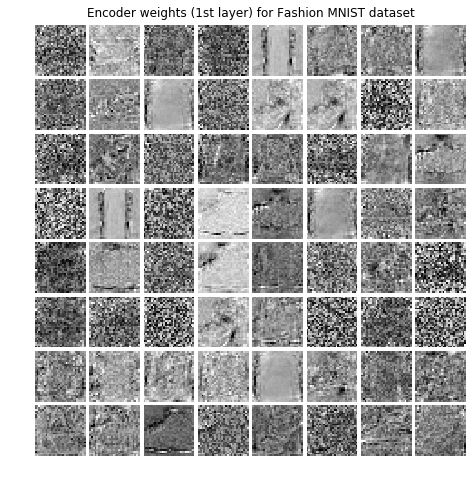

In [11]:
grid_vis(vae.encoder[0].weight.detach(), 
         rows=8, cols=8, norm_img=True,
         figsize=(16, 8), 
         plt_title='Encoder weights (1st layer) for Fashion MNIST dataset')

## 5. Evaluating the model

In [12]:
# Prepare train and test batches for evaluation
X_train_batch = np.zeros((15, 1, 28, 28))
X_test_batch = np.zeros((15, 1, 28, 28))

for idx in range(15):
    X_train_batch[idx] = X_train[y_train==(idx%10)][idx]
    X_test_batch[idx] = X_test[y_test==(idx%10)][idx]

X_train_batch = torch.Tensor(X_train_batch).to(device)
X_test_batch = torch.Tensor(X_test_batch).to(device)

### 5.1 Reconstructions

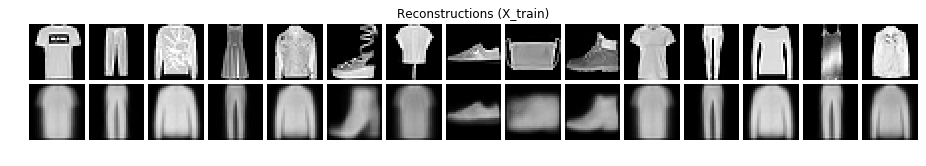

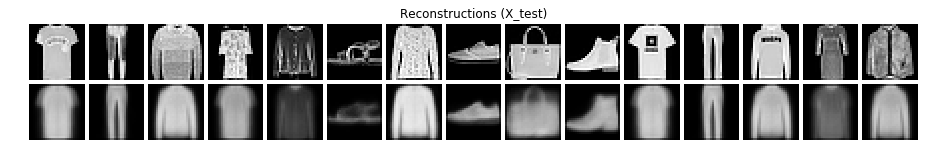

In [13]:
with torch.no_grad():
    recon_train, _, _ = vae(X_train_batch)
    recon_test, _, _ = vae(X_test_batch)

grid_vis(torch.cat((X_train_batch, recon_train)), 
         rows=2, cols=15, plt_title='Reconstructions (X_train)')
grid_vis(torch.cat((X_test_batch, recon_test)), 
         rows=2, cols=15, plt_title='Reconstructions (X_test)')

### 5.2 Samples from the model

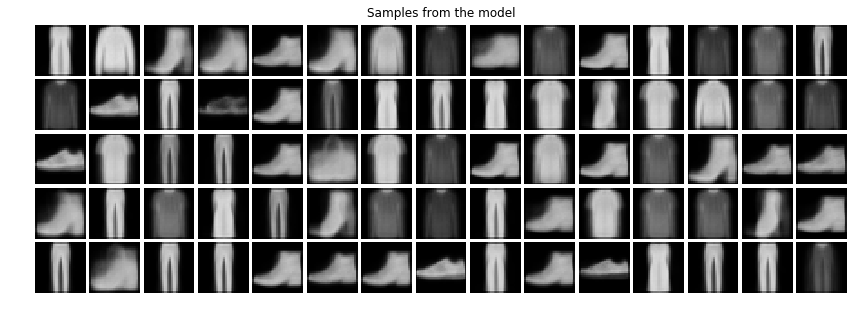

In [14]:
X_gen = vae.generate(nsamples=75)
grid_vis(X_gen, plt_title='Samples from the model')

### 5.3 Walk the latent space :)

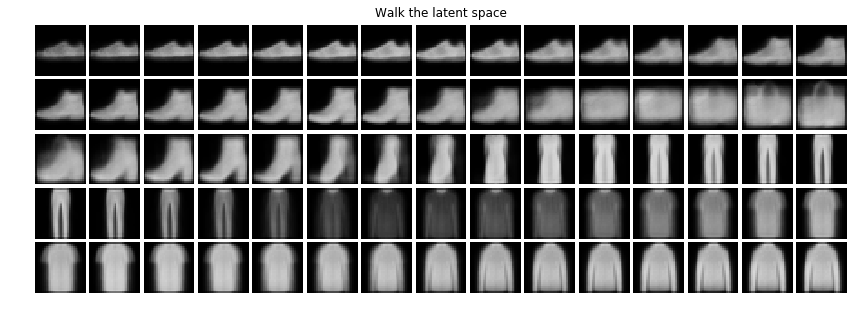

In [15]:
N = 75
noise_np = np.tile(np.linspace(-2, 2, N), (NZ, 1)).T
noise = torch.Tensor(noise_np).to(device)
X_gen = vae.generate(noise=noise)
grid_vis(X_gen, plt_title='Walk the latent space')

### 5.4 Latent space for a test batch

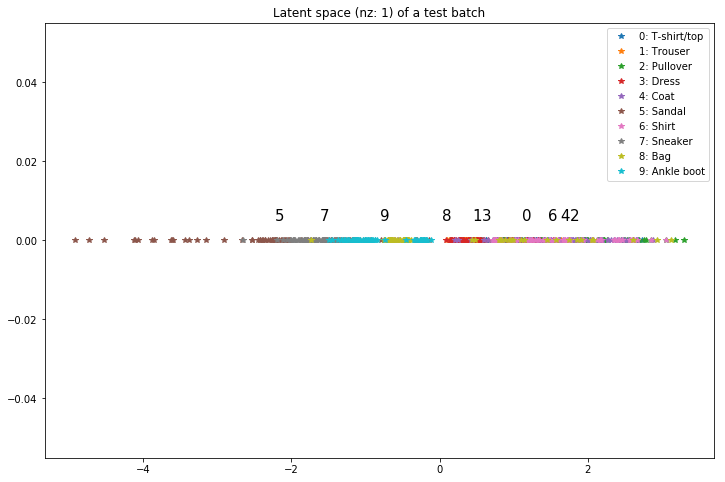

In [16]:
# Prepare a bigger test batch
test_batch_size = 700
X_test_batch = np.zeros((test_batch_size, 1, 28, 28))

for idx in range(test_batch_size):
    X_test_batch[idx] = X_test[y_test==(idx%10)][idx]

X_test_batch = torch.Tensor(X_test_batch).to(device)

# get latent vector z
z = vae.get_z(X_test_batch)
z_np = z.cpu().detach().numpy()

if NZ <= 2:
    plt.figure(figsize=(12, 8))
    plt.title(f'Latent space (nz: {NZ}) of a test batch')
    for class_id in range(10):
        x = []
        y = []
        if NZ == 1:
            x = z_np[class_id::10]
            y = np.zeros(test_batch_size//10)
            x_text = np.mean(x)
            y_text = np.mean(y) + .005
        elif NZ == 2:
            x = z_np[class_id::10, 0]
            y = z_np[class_id::10, 1]
            x_text = np.mean(x)
            y_text = np.mean(y)

        plt.plot(x, y, '*', label=f'{class_id}: {class_desc[class_id]}')
        plt.text(x_text, y_text, class_id, fontsize=15)
    
    plt.legend()
    plt.show()